In [1]:
import torchvision
print(torchvision.__version__)

0.21.0+cu124


In [2]:
from utils import Config
from data_loader import MultiOmicsDataset, create_dataloaders

In [3]:
# # Reload all modules every time before executing code
%load_ext autoreload
%autoreload 2  

### 7. Run pytest

In [4]:
%%bash
pytest -v


============================= test session starts ==============================
platform linux -- Python 3.11.11, pytest-8.3.5, pluggy-1.5.0 -- /home/CBBI/wangh5/miniforge3/envs/cs7643_a4_generative/bin/python3.11
cachedir: .pytest_cache
rootdir: /home/CBBI/wangh5/_PyCharm/proj_dl
configfile: pytest.ini
plugins: anyio-4.9.0
collecting ... collected 5 items

tests/test_02_model_components.py::test_vae_forward PASSED               [ 20%]
tests/test_02_model_components.py::test_mirna_vae_forward PASSED         [ 40%]
tests/test_02_model_components.py::test_mini_convnext PASSED             [ 60%]
tests/test_02_model_components.py::test_transformer_fusion PASSED        [ 80%]
tests/test_02_model_components.py::test_fusion_classifier PASSED         [100%]

============================== 5 passed in 0.29s ===============================


In [5]:
import json
from pathlib import Path
from sklearn.metrics import classification_report, accuracy_score
import torch

In [6]:
from utils import Config
from data_loader import MultiOmicsDataset, create_dataloaders
from models import MultiOmicsClassifier 
from trainers import BaseTrainer
from losses import MultiOmicsLoss

In [7]:
def get_training_parameters(trainer, include_model_info=False, include_optimizer_state=False):
    """Extracts all relevant training parameters in a structured dictionary.
    
    Args:
        trainer: BaseTrainer instance
        include_model_info: Whether to include model architecture details
        include_optimizer_state: Whether to include optimizer state details
        
    Returns:
        Dictionary containing all training parameters
    """
    params = {
        "training": {
            "device": str(trainer.device),
        },
        "loss": {
            "type": type(trainer.loss_fn).__name__,
            "beta": getattr(trainer.loss_fn, 'target_beta', None),
            "use_focal": getattr(trainer.loss_fn, 'use_focal', None),
            "focal_gamma": getattr(trainer.loss_fn, 'focal_gamma', None),
            "label_smoothing": getattr(trainer.loss_fn, 'label_smoothing', None),
            "kl_epsilon": getattr(trainer.loss_fn, 'kl_epsilon', None)
        },
        "optimizer": {
            "type": type(trainer.optimizer).__name__,
            "lr": trainer.optimizer.param_groups[0]['lr'],
            "betas": trainer.optimizer.param_groups[0].get('betas', None),
            "eps": trainer.optimizer.param_groups[0].get('eps', None),
            "weight_decay": trainer.optimizer.param_groups[0].get('weight_decay', None)
        }
    }
    
    if include_model_info:
        params["model"] = {
            "type": type(trainer.model).__name__,
            "total_parameters": sum(p.numel() for p in trainer.model.parameters()),
            "trainable_parameters": sum(p.numel() for p in trainer.model.parameters() 
                                      if p.requires_grad),
            "architecture": str(trainer.model)  # This shows the model structure
        }
    
    if include_optimizer_state:
        params["optimizer"]["state"] = {
            "momentum_buffer": any('momentum_buffer' in p for p in trainer.optimizer.state.values())
        }

    
    return params



# params = get_training_parameters(trainer)
# print(json.dumps(params, indent=4))


In [8]:
config = Config.from_yaml("configs/data_config.yaml")

dataset = MultiOmicsDataset(config)
dataloaders = create_dataloaders(dataset, config)



In [9]:

mirna_dim = 1046
rna_exp_dim = 13054
methy_shape = (50, 100)  # e.g., (50, 100)
latent_dim = 16
num_classes = 5

# Instantiate model
multiomics_model = MultiOmicsClassifier(
    mirna_dim=mirna_dim,
    rna_exp_dim=rna_exp_dim,
    methy_shape=methy_shape,
    latent_dim=latent_dim,
    num_classes=num_classes
)

In [174]:
trainer = BaseTrainer(
    model=multiomics_model,
    optimizer=torch.optim.Adam(multiomics_model.parameters(), lr=1e-3),
    loss_fn=MultiOmicsLoss(),
    device='cuda'
)

trainer.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=10)



Epoch 1/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s, loss=1.45]


step     1 | loss: 1.6811 | ce: 1.6005 | kl: 10.6288 | beta: 0.0076
step     2 | loss: 1.5952 | ce: 1.4728 | kl: 16.1330 | beta: 0.0076
step     3 | loss: 1.5808 | ce: 1.4872 | kl: 12.3249 | beta: 0.0076
step     4 | loss: 1.4581 | ce: 1.3691 | kl: 11.7229 | beta: 0.0076
step     5 | loss: 1.4465 | ce: 1.3520 | kl: 12.4251 | beta: 0.0076
Train Loss: 1.5523


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss:   3.4369

Epoch 2/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.71it/s, loss=1.31]


step     8 | loss: 1.3918 | ce: 1.2796 | kl: 14.7446 | beta: 0.0076
step     9 | loss: 1.3924 | ce: 1.2828 | kl: 14.4055 | beta: 0.0076
step    10 | loss: 1.3355 | ce: 1.2316 | kl: 13.6405 | beta: 0.0076
step    11 | loss: 1.2698 | ce: 1.1553 | kl: 15.0126 | beta: 0.0076
step    12 | loss: 1.3107 | ce: 1.2060 | kl: 13.7215 | beta: 0.0076
Train Loss: 1.3400


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


Val Loss:   1.9519

Epoch 3/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s, loss=1.09]


step    15 | loss: 1.2659 | ce: 1.1536 | kl: 14.7169 | beta: 0.0076
step    16 | loss: 1.2156 | ce: 1.0998 | kl: 15.1563 | beta: 0.0076
step    17 | loss: 1.1333 | ce: 1.0199 | kl: 14.8305 | beta: 0.0076
step    18 | loss: 1.2494 | ce: 1.1341 | kl: 15.0762 | beta: 0.0076
step    19 | loss: 1.0895 | ce: 0.9702 | kl: 15.5931 | beta: 0.0076
Train Loss: 1.1907


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.80it/s]


Val Loss:   1.4235

Epoch 4/10


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.51it/s, loss=0.938]


step    22 | loss: 1.0489 | ce: 0.9309 | kl: 15.4027 | beta: 0.0077
step    23 | loss: 1.0829 | ce: 0.9603 | kl: 15.9944 | beta: 0.0077
step    24 | loss: 0.9966 | ce: 0.8755 | kl: 15.7859 | beta: 0.0077
step    25 | loss: 1.0095 | ce: 0.8899 | kl: 15.5966 | beta: 0.0077
step    26 | loss: 0.9378 | ce: 0.8142 | kl: 16.1069 | beta: 0.0077
Train Loss: 1.0151


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.70it/s]


Val Loss:   1.5971

Epoch 5/10


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.82it/s, loss=0.797]


step    29 | loss: 0.9671 | ce: 0.8346 | kl: 17.2362 | beta: 0.0077
step    30 | loss: 0.8175 | ce: 0.6913 | kl: 16.4116 | beta: 0.0077
step    31 | loss: 0.9586 | ce: 0.8220 | kl: 17.7613 | beta: 0.0077
step    32 | loss: 0.8821 | ce: 0.7578 | kl: 16.1493 | beta: 0.0077
step    33 | loss: 0.7966 | ce: 0.6697 | kl: 16.4896 | beta: 0.0077
Train Loss: 0.8844


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.82it/s]


Val Loss:   1.4864

Epoch 6/10


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s, loss=0.759]


step    36 | loss: 0.8003 | ce: 0.6721 | kl: 16.6328 | beta: 0.0077
step    37 | loss: 0.7718 | ce: 0.6452 | kl: 16.4129 | beta: 0.0077
step    38 | loss: 0.7045 | ce: 0.5838 | kl: 15.6495 | beta: 0.0077
step    39 | loss: 0.7449 | ce: 0.6218 | kl: 15.9469 | beta: 0.0077
step    40 | loss: 0.7590 | ce: 0.6338 | kl: 16.2149 | beta: 0.0077
Train Loss: 0.7561


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Val Loss:   0.9737

Epoch 7/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.91it/s, loss=0.56]


step    43 | loss: 0.6963 | ce: 0.5671 | kl: 16.7018 | beta: 0.0077
step    44 | loss: 0.6146 | ce: 0.4851 | kl: 16.7421 | beta: 0.0077
step    45 | loss: 0.6458 | ce: 0.5148 | kl: 16.9130 | beta: 0.0077
step    46 | loss: 0.5873 | ce: 0.4540 | kl: 17.2052 | beta: 0.0077
step    47 | loss: 0.5598 | ce: 0.4425 | kl: 15.1308 | beta: 0.0077
Train Loss: 0.6207


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.04it/s]


Val Loss:   1.0775

Epoch 8/10


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.41it/s, loss=0.495]


step    50 | loss: 0.5190 | ce: 0.3990 | kl: 15.4647 | beta: 0.0078
step    51 | loss: 0.6040 | ce: 0.4932 | kl: 14.2698 | beta: 0.0078
step    52 | loss: 0.4915 | ce: 0.3771 | kl: 14.7358 | beta: 0.0078
step    53 | loss: 0.4670 | ce: 0.3590 | kl: 13.8943 | beta: 0.0078
step    54 | loss: 0.4955 | ce: 0.3876 | kl: 13.8806 | beta: 0.0078
Train Loss: 0.5154


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]


Val Loss:   0.8833

Epoch 9/10


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.32it/s, loss=0.424]


step    57 | loss: 0.5210 | ce: 0.4121 | kl: 13.9805 | beta: 0.0078
step    58 | loss: 0.4410 | ce: 0.3328 | kl: 13.8934 | beta: 0.0078
step    59 | loss: 0.4543 | ce: 0.3477 | kl: 13.6719 | beta: 0.0078
step    60 | loss: 0.4505 | ce: 0.3407 | kl: 14.0900 | beta: 0.0078
step    61 | loss: 0.4241 | ce: 0.3131 | kl: 14.2331 | beta: 0.0078
Train Loss: 0.4582


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.36it/s]


Val Loss:   0.8395

Epoch 10/10


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s, loss=0.433]


step    64 | loss: 0.5647 | ce: 0.4547 | kl: 14.0852 | beta: 0.0078
step    65 | loss: 0.4220 | ce: 0.3010 | kl: 15.4777 | beta: 0.0078
step    66 | loss: 0.4080 | ce: 0.2942 | kl: 14.5499 | beta: 0.0078
step    67 | loss: 0.4143 | ce: 0.2983 | kl: 14.8365 | beta: 0.0078
step    68 | loss: 0.4331 | ce: 0.3173 | kl: 14.7976 | beta: 0.0078
Train Loss: 0.4484


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.61it/s]

Val Loss:   1.1692


In [177]:
preds, targets = trainer.predict(dataloaders["test"])

# Compute accuracy
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

✅ Test Accuracy: 0.6818


In [178]:
preds, targets = trainer.predict(dataloaders["test"])

# Compute accuracy
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")




✅ Test Accuracy: 0.7576


In [180]:

print(classification_report(targets.numpy(), preds.numpy()))

params = get_training_parameters(trainer)
print(json.dumps(params, indent=4))


              precision    recall  f1-score   support

           0       0.87      0.69      0.77        29
           1       0.60      0.80      0.69        15
           2       0.89      0.89      0.89         9
           3       0.69      1.00      0.82         9
           4       1.00      0.25      0.40         4

    accuracy                           0.76        66
   macro avg       0.81      0.73      0.71        66
weighted avg       0.79      0.76      0.75        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 0.1,
        "use_focal": false,
        "focal_gamma": 2.0,
        "label_smoothing": 0.0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 0.001,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


In [181]:
trainer = BaseTrainer(
    model=multiomics_model,
    optimizer=torch.optim.Adam(multiomics_model.parameters(), lr=2e-5),
    loss_fn=MultiOmicsLoss(
                use_focal=False,
                # focal_gamma=2,        # Reduced from 0.5 for gentler hard example focus
                beta=1,               # Lower KL divergence weight
                # label_smoothing=0.1,    # Added smoothing
                class_weights=None  # torch.tensor([1.0, 1.5, 1.0, 1.0, 2.0], device="cuda")  # Targeted rebalancing
),
    device='cuda'
)

trainer.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=10)


Epoch 1/10


Training:   0%|                                                                                                                                                                                                                                        | 0/5 [00:00<?, ?it/s]/home/CBBI/wangh5/_PyCharm/proj_dl/losses/multi_omics.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'beta': torch.tensor(self.beta, device=self.current_step.device)
Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.31it/s, loss=1.38]


step     1 | loss: 1.3884 | ce: 0.2444 | kl: 15.0817 | beta: 0.0759
step     2 | loss: 1.3616 | ce: 0.2149 | kl: 15.1090 | beta: 0.0759
step     3 | loss: 1.2858 | ce: 0.2018 | kl: 14.2764 | beta: 0.0759
step     4 | loss: 1.5350 | ce: 0.3191 | kl: 16.0058 | beta: 0.0760
step     5 | loss: 1.3761 | ce: 0.2385 | kl: 14.9687 | beta: 0.0760
Train Loss: 1.3894


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.51it/s]


Val Loss:   1.7002

Epoch 2/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.84it/s, loss=1.47]


step     8 | loss: 1.2782 | ce: 0.2502 | kl: 13.5076 | beta: 0.0761
step     9 | loss: 1.4166 | ce: 0.3285 | kl: 14.2913 | beta: 0.0761
step    10 | loss: 1.2747 | ce: 0.2449 | kl: 13.5191 | beta: 0.0762
step    11 | loss: 1.3343 | ce: 0.3174 | kl: 13.3435 | beta: 0.0762
step    12 | loss: 1.4679 | ce: 0.3445 | kl: 14.7338 | beta: 0.0762
Train Loss: 1.3543


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.93it/s]


Val Loss:   1.7782

Epoch 3/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.66it/s, loss=1.15]


step    15 | loss: 1.3790 | ce: 0.3189 | kl: 13.8850 | beta: 0.0764
step    16 | loss: 1.3306 | ce: 0.3435 | kl: 12.9225 | beta: 0.0764
step    17 | loss: 1.3115 | ce: 0.2949 | kl: 13.3026 | beta: 0.0764
step    18 | loss: 1.2646 | ce: 0.2650 | kl: 13.0733 | beta: 0.0765
step    19 | loss: 1.1462 | ce: 0.2122 | kl: 12.2100 | beta: 0.0765
Train Loss: 1.2864


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.00it/s]


Val Loss:   1.6747

Epoch 4/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.79it/s, loss=1.23]


step    22 | loss: 1.3173 | ce: 0.3238 | kl: 12.9706 | beta: 0.0766
step    23 | loss: 1.1850 | ce: 0.2628 | kl: 12.0338 | beta: 0.0766
step    24 | loss: 1.2360 | ce: 0.2450 | kl: 12.9256 | beta: 0.0767
step    25 | loss: 1.2104 | ce: 0.2663 | kl: 12.3084 | beta: 0.0767
step    26 | loss: 1.2265 | ce: 0.3386 | kl: 11.5700 | beta: 0.0767
Train Loss: 1.2351


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.12it/s]


Val Loss:   1.7607

Epoch 5/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s, loss=1.22]


step    29 | loss: 1.1322 | ce: 0.2608 | kl: 11.3397 | beta: 0.0768
step    30 | loss: 1.1986 | ce: 0.3031 | kl: 11.6482 | beta: 0.0769
step    31 | loss: 1.1742 | ce: 0.3162 | kl: 11.1555 | beta: 0.0769
step    32 | loss: 1.1290 | ce: 0.2533 | kl: 11.3795 | beta: 0.0770
step    33 | loss: 1.2241 | ce: 0.3498 | kl: 11.3569 | beta: 0.0770
Train Loss: 1.1716


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]


Val Loss:   0.9290

Epoch 6/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.54it/s, loss=1.06]


step    36 | loss: 1.0760 | ce: 0.2084 | kl: 11.2546 | beta: 0.0771
step    37 | loss: 1.1733 | ce: 0.2932 | kl: 11.4102 | beta: 0.0771
step    38 | loss: 1.1178 | ce: 0.2951 | kl: 10.6608 | beta: 0.0772
step    39 | loss: 1.0720 | ce: 0.2618 | kl: 10.4946 | beta: 0.0772
step    40 | loss: 1.0627 | ce: 0.2721 | kl: 10.2364 | beta: 0.0772
Train Loss: 1.1003


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]


Val Loss:   0.8711

Epoch 7/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.07it/s, loss=1.06]


step    43 | loss: 1.0304 | ce: 0.2731 | kl: 9.7911 | beta: 0.0773
step    44 | loss: 1.1288 | ce: 0.3001 | kl: 10.7106 | beta: 0.0774
step    45 | loss: 1.0995 | ce: 0.3084 | kl: 10.2188 | beta: 0.0774
step    46 | loss: 1.0473 | ce: 0.3000 | kl: 9.6491 | beta: 0.0775
step    47 | loss: 1.0583 | ce: 0.2798 | kl: 10.0462 | beta: 0.0775
Train Loss: 1.0729


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]


Val Loss:   1.4520

Epoch 8/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s, loss=1.01]


step    50 | loss: 1.0614 | ce: 0.2865 | kl: 9.9861 | beta: 0.0776
step    51 | loss: 1.0340 | ce: 0.2858 | kl: 9.6378 | beta: 0.0776
step    52 | loss: 1.0012 | ce: 0.2828 | kl: 9.2501 | beta: 0.0777
step    53 | loss: 1.0272 | ce: 0.3462 | kl: 8.7645 | beta: 0.0777
step    54 | loss: 1.0143 | ce: 0.2856 | kl: 9.3744 | beta: 0.0777
Train Loss: 1.0276


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.07it/s]


Val Loss:   1.5720

Epoch 9/10


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s, loss=1.06]


step    57 | loss: 0.8603 | ce: 0.2209 | kl: 8.2135 | beta: 0.0778
step    58 | loss: 0.9746 | ce: 0.2613 | kl: 9.1594 | beta: 0.0779
step    59 | loss: 1.0908 | ce: 0.4131 | kl: 8.6987 | beta: 0.0779
step    60 | loss: 0.9960 | ce: 0.3114 | kl: 8.7827 | beta: 0.0780
step    61 | loss: 1.0642 | ce: 0.3491 | kl: 9.1687 | beta: 0.0780
Train Loss: 0.9972


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.92it/s]


Val Loss:   1.4476

Epoch 10/10


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s, loss=0.965]


step    64 | loss: 0.9070 | ce: 0.2575 | kl: 8.3168 | beta: 0.0781
step    65 | loss: 1.0389 | ce: 0.3574 | kl: 8.7225 | beta: 0.0781
step    66 | loss: 0.9347 | ce: 0.3014 | kl: 8.1023 | beta: 0.0782
step    67 | loss: 1.0095 | ce: 0.3417 | kl: 8.5399 | beta: 0.0782
step    68 | loss: 0.9646 | ce: 0.3463 | kl: 7.9023 | beta: 0.0782
Train Loss: 0.9710


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]

Val Loss:   1.4375


In [185]:
preds, targets = trainer.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer)

print(json.dumps(params, indent=4))



✅ Test Accuracy: 0.6818
              precision    recall  f1-score   support

           0       0.76      0.66      0.70        29
           1       0.42      0.53      0.47        15
           2       0.89      0.89      0.89         9
           3       0.75      1.00      0.86         9
           4       1.00      0.25      0.40         4

    accuracy                           0.68        66
   macro avg       0.76      0.67      0.66        66
weighted avg       0.71      0.68      0.68        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 1,
        "use_focal": false,
        "focal_gamma": 2.0,
        "label_smoothing": 0.0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 2e-05,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


In [9]:
from trainers import CallbackTrainer
from callbacks import LossRecorderCallback, TSNERecorderCallback
from callbacks import LossRecorderCallback, TSNERecorderCallback

def extract_latent(outputs):
    """Example: Extract latent representation from your specific model outputs"""
    return outputs['latent_rep']  # Replace with your actual latent key
    # Or if using concatenated features:
    # return torch.cat([outputs['mirna_latent'], outputs['rna_latent']], dim=1)



In [115]:
loss_fn = MultiOmicsLoss(
    beta=0.25,               # Target KL weight
    # annealing_steps=5000,   # Total steps to anneal over
    # use_focal=True,
    # focal_gamma=1,
    # label_smoothing=0.1,
    # class_weights=None # or torch.tensor([...], device="cuda")
)

mirna_dim = 1046
rna_exp_dim = 13054
methy_shape = (50, 100)  # e.g., (50, 100)
latent_dim = 32
num_classes = 5

# Instantiate model
multiomics_model = MultiOmicsClassifier(
    mirna_dim=mirna_dim,
    rna_exp_dim=rna_exp_dim,
    methy_shape=methy_shape,
    latent_dim=latent_dim,
    num_classes=num_classes
)




loss_callback = LossRecorderCallback(save_path="logs/loss_history.json")
tsne_callback = TSNERecorderCallback(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device='cuda',
    save_path="tsne_results.pkl"  # Matches your plot_tsne() default
)

trainer_cb = CallbackTrainer(
    model=multiomics_model,
    optimizer=torch.optim.AdamW(multiomics_model.parameters(), lr=2e-4, weight_decay=0.01),
    loss_fn=loss_fn,
    device='cuda', 
    callbacks=[loss_callback, tsne_callback]
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)


Epoch 1/50


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s, loss=1.8]


Train Loss: 1.9485


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.92it/s]

Val Loss:   3.6521



Epoch 2/50


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.27it/s, loss=1.7]


step    10 | loss: 1.6537 | ce: 1.4284 | kl: 11.8321 | beta: 0.0190
Train Loss: 1.6954


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.30it/s]

Val Loss:   2.1649



Epoch 3/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s, loss=1.35]


Train Loss: 1.5239


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.58it/s]

Val Loss:   1.7674



Epoch 4/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s, loss=1.44]


Train Loss: 1.4704


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.07it/s]

Val Loss:   1.4904



Epoch 5/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s, loss=1.25]


step    30 | loss: 1.5268 | ce: 1.3682 | kl: 8.2495 | beta: 0.0192
Train Loss: 1.3827


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.48it/s]

Val Loss:   1.4035



Epoch 6/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s, loss=1.52]


step    40 | loss: 1.5153 | ce: 1.3517 | kl: 8.4733 | beta: 0.0193
Train Loss: 1.3807


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.38it/s]

Val Loss:   1.3585



Epoch 7/50


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.78it/s, loss=1.3]


Train Loss: 1.2816


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.66it/s]

Val Loss:   1.3725



Epoch 8/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.17it/s, loss=1.52]


step    50 | loss: 1.2381 | ce: 1.0590 | kl: 9.2321 | beta: 0.0194
Train Loss: 1.2567


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.75it/s]

Val Loss:   1.3528



Epoch 9/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.03it/s, loss=0.942]


step    60 | loss: 1.1369 | ce: 0.9247 | kl: 10.8868 | beta: 0.0195
Train Loss: 1.0811


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.48it/s]

Val Loss:   1.3574



Epoch 10/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s, loss=1]


Train Loss: 1.0010


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.66it/s]

Val Loss:   1.9929



Epoch 11/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s, loss=0.931]


Train Loss: 0.9554


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]

Val Loss:   1.6957



Epoch 12/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s, loss=0.827]


step    80 | loss: 0.9182 | ce: 0.6776 | kl: 12.2350 | beta: 0.0197
Train Loss: 0.8730


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.54it/s]

Val Loss:   1.1250



Epoch 13/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s, loss=0.885]


Train Loss: 0.8373


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]

Val Loss:   1.2493



Epoch 14/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s, loss=1.25]


Train Loss: 0.8536


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.50it/s]

Val Loss:   1.0734



Epoch 15/50


Training:  20%|██████████████████████████████████████████▍                                                                                                                                                                         | 1/5 [00:00<00:01,  2.72it/s, loss=0.683]

step   100 | loss: 0.6648 | ce: 0.4551 | kl: 10.5633 | beta: 0.0199


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.12it/s, loss=0.683]


Train Loss: 0.7008


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.28it/s]

Val Loss:   1.0668



Epoch 16/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s, loss=0.72]


step   110 | loss: 0.7203 | ce: 0.5130 | kl: 10.3952 | beta: 0.0199
Train Loss: 0.7310


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]

Val Loss:   1.0500



Epoch 17/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s, loss=0.721]


Train Loss: 0.6962


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.39it/s]

Val Loss:   1.0316



Epoch 18/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.40it/s, loss=1.57]


step   120 | loss: 0.6346 | ce: 0.4261 | kl: 10.4114 | beta: 0.0200
Train Loss: 0.8395


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.57it/s]

Val Loss:   0.8950



Epoch 19/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.04it/s, loss=1]


step   130 | loss: 0.7258 | ce: 0.4731 | kl: 12.5532 | beta: 0.0201
Train Loss: 0.7497


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]

Val Loss:   1.1444



Epoch 20/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.21it/s, loss=1.23]


Train Loss: 0.7994


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.20it/s]

Val Loss:   1.3316



Epoch 21/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.74it/s, loss=0.499]


Train Loss: 0.6008


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]

Val Loss:   0.9568



Epoch 22/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.91it/s, loss=0.716]


step   150 | loss: 0.6142 | ce: 0.3804 | kl: 11.5076 | beta: 0.0203
Train Loss: 0.6088


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.05it/s]

Val Loss:   0.9105



Epoch 23/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.71it/s, loss=0.55]


Train Loss: 0.5108


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.56it/s]

Val Loss:   0.8864



Epoch 24/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.08it/s, loss=0.334]


Train Loss: 0.5000


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.62it/s]

Val Loss:   1.2113



Epoch 25/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.73it/s, loss=0.38]


step   170 | loss: 0.4509 | ce: 0.2122 | kl: 11.6425 | beta: 0.0205
Train Loss: 0.4879


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.79it/s]

Val Loss:   1.0437



Epoch 26/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.93it/s, loss=0.598]


step   180 | loss: 0.5981 | ce: 0.3329 | kl: 12.8762 | beta: 0.0206
Train Loss: 0.5060


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.62it/s]

Val Loss:   0.8490



Epoch 27/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.31it/s, loss=0.363]


Train Loss: 0.4459


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.97it/s]

Val Loss:   0.8112



Epoch 28/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s, loss=0.535]


step   190 | loss: 0.3585 | ce: 0.1524 | kl: 9.9609 | beta: 0.0207
Train Loss: 0.4371


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   1.0669



Epoch 29/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s, loss=0.536]


step   200 | loss: 0.4157 | ce: 0.1810 | kl: 11.2903 | beta: 0.0208
Train Loss: 0.4346


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.65it/s]

Val Loss:   1.4046



Epoch 30/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s, loss=0.407]


Train Loss: 0.4215


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.61it/s]

Val Loss:   1.3922



Epoch 31/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.58it/s, loss=0.832]


Train Loss: 0.4805


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.84it/s]

Val Loss:   0.8430



Epoch 32/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.97it/s, loss=0.839]


step   220 | loss: 0.5306 | ce: 0.3065 | kl: 10.6829 | beta: 0.0210
Train Loss: 0.5252


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.36it/s]

Val Loss:   0.9081



Epoch 33/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s, loss=0.515]


Train Loss: 0.4513


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.26it/s]

Val Loss:   1.0145



Epoch 34/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.80it/s, loss=0.304]


Train Loss: 0.4297


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.44it/s]

Val Loss:   1.6708



Epoch 35/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.44it/s, loss=0.494]


step   240 | loss: 0.3813 | ce: 0.1604 | kl: 10.4335 | beta: 0.0212
Train Loss: 0.4545


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.48it/s]

Val Loss:   1.1380



Epoch 36/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.89it/s, loss=0.511]


step   250 | loss: 0.5106 | ce: 0.2603 | kl: 11.7681 | beta: 0.0213
Train Loss: 0.4342


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.53it/s]

Val Loss:   1.4352



Epoch 37/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.54it/s, loss=0.325]


Train Loss: 0.4054


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   1.3822



Epoch 38/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s, loss=1.62]


step   260 | loss: 0.3955 | ce: 0.1860 | kl: 9.8066 | beta: 0.0214
Train Loss: 0.6263


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.34it/s]

Val Loss:   1.0205



Epoch 39/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.44it/s, loss=0.614]


step   270 | loss: 0.5596 | ce: 0.3387 | kl: 10.2948 | beta: 0.0215
Train Loss: 0.4679


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.03it/s]

Val Loss:   0.7761



Epoch 40/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s, loss=0.427]


Train Loss: 0.5095


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   1.0331



Epoch 41/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s, loss=0.629]


Train Loss: 0.4899


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.40it/s]

Val Loss:   0.7591



Epoch 42/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.18it/s, loss=1.02]


step   290 | loss: 0.4763 | ce: 0.2168 | kl: 11.9821 | beta: 0.0217
Train Loss: 0.5200


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.10it/s]

Val Loss:   0.8866



Epoch 43/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.48it/s, loss=1.01]


Train Loss: 0.5625


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]

Val Loss:   1.5091



Epoch 44/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.61it/s, loss=0.512]


Train Loss: 0.4464


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.25it/s]

Val Loss:   0.9613



Epoch 45/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.02it/s, loss=0.615]


step   310 | loss: 0.4571 | ce: 0.1766 | kl: 12.8322 | beta: 0.0219
Train Loss: 0.4595


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   0.9512



Epoch 46/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.50it/s, loss=0.316]


step   320 | loss: 0.3157 | ce: 0.0834 | kl: 10.5829 | beta: 0.0220
Train Loss: 0.3380


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   0.7501



Epoch 47/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.29it/s, loss=0.366]


Train Loss: 0.3592


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.64it/s]

Val Loss:   0.8629



Epoch 48/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.87it/s, loss=0.656]


step   330 | loss: 0.3651 | ce: 0.1805 | kl: 8.3727 | beta: 0.0221
Train Loss: 0.3887


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.02it/s]

Val Loss:   0.6109



Epoch 49/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.72it/s, loss=1.42]


step   340 | loss: 0.3426 | ce: 0.1403 | kl: 9.1280 | beta: 0.0222
Train Loss: 0.5407


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.88it/s]

Val Loss:   0.8680



Epoch 50/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.28it/s, loss=0.322]


Train Loss: 0.3674


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.36it/s]

Val Loss:   0.9066


In [116]:
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

✅ Test Accuracy: 0.6667
              precision    recall  f1-score   support

           0       0.66      0.79      0.72        29
           1       0.54      0.47      0.50        15
           2       0.78      0.78      0.78         9
           3       0.75      0.67      0.71         9
           4       1.00      0.25      0.40         4

    accuracy                           0.67        66
   macro avg       0.74      0.59      0.62        66
weighted avg       0.68      0.67      0.66        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 0.25,
        "use_focal": false,
        "focal_gamma": 2.0,
        "label_smoothing": 0.0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.01
    }
}


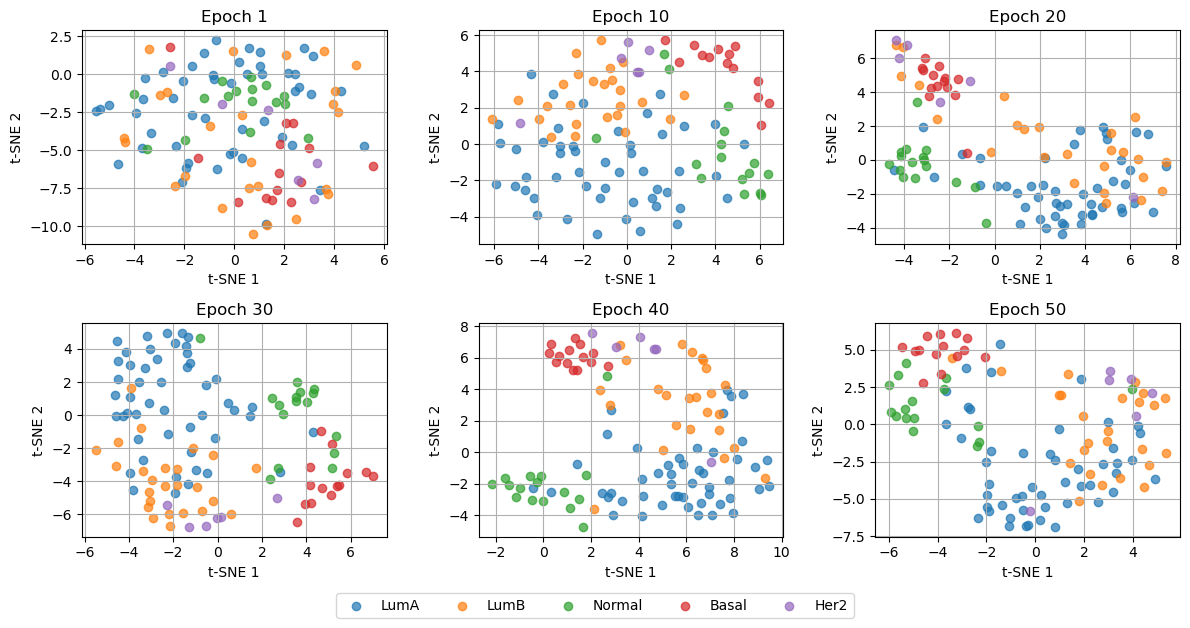

In [117]:

from utils import plot_tsne, plot_loss

plot_tsne(epochs=[1, 10, 20, 30, 40, 50], figsize=(4,3)) 

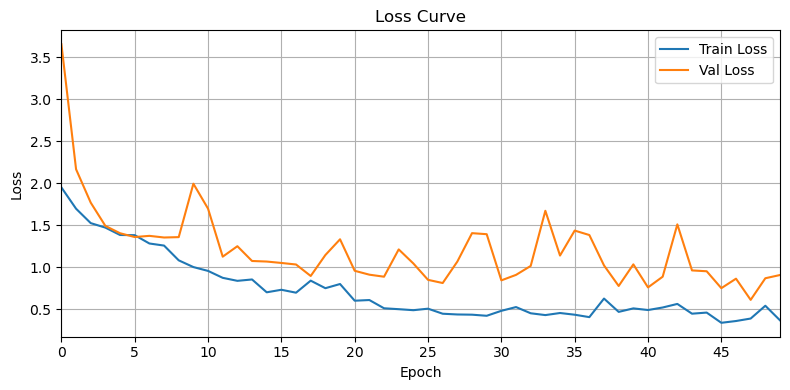

In [118]:
plot_loss(loss_path="logs/loss_history.json", figsize=(8, 4))

In [18]:
# trainer = BaseTrainer(
#     model=multiomics_model,
#     optimizer=torch.optim.Adam(multiomics_model.parameters(), lr=1e-4),
#     loss_fn=MultiOmicsLoss(),
#     device='cuda'
# )

# trainer.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=10)

loss_fn = MultiOmicsLoss(
    beta=0.1,               # Target KL weight
    annealing_steps=5000,   # Total steps to anneal over
    use_focal=True,
    focal_gamma=1,
    label_smoothing=0.1,
    class_weights=torch.tensor([1.0, 2.5, 1.0, 1.0, 1.5], device="cuda") # or torch.tensor([...], device="cuda")
)

mirna_dim = 1046
rna_exp_dim = 13054
methy_shape = (50, 100)  # e.g., (50, 100)
latent_dim = 32
num_classes = 5

# Instantiate model
multiomics_model = MultiOmicsClassifier(
    mirna_dim=mirna_dim,
    rna_exp_dim=rna_exp_dim,
    methy_shape=methy_shape,
    latent_dim=latent_dim,
    num_classes=num_classes
)




loss_callback = LossRecorderCallback(save_path="logs/loss_history.json")
tsne_callback = TSNERecorderCallback(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device='cuda',
    save_path="tsne_results.pkl"  # Matches your plot_tsne() default
)

trainer_cb = CallbackTrainer(
    model=multiomics_model,
    optimizer=torch.optim.Adam(multiomics_model.parameters(), lr=2e-4),
    loss_fn=loss_fn,
    device='cuda', 
    callbacks=[loss_callback, tsne_callback]
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)

/home/CBBI/wangh5/_PyCharm/proj_dl/losses/focal.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('weight', torch.tensor(weight) if weight is not None else None)



Epoch 1/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s, loss=2.07]


Train Loss: 1.9079


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.19it/s]

Val Loss:   2.9910



Epoch 2/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.94it/s, loss=1.77]


step    10 | loss: 1.7042 | ce: 1.5532 | kl: 19.7359 | beta: 0.0076
Train Loss: 1.6803


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.84it/s]

Val Loss:   2.0878



Epoch 3/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.06it/s, loss=1.68]


Train Loss: 1.5518


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]

Val Loss:   1.5809



Epoch 4/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s, loss=1.26]


Train Loss: 1.3826


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.01it/s]

Val Loss:   1.5596



Epoch 5/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.64it/s, loss=1.33]


step    30 | loss: 1.2200 | ce: 1.0819 | kl: 17.7204 | beta: 0.0078
Train Loss: 1.2894


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.34it/s]

Val Loss:   1.2939



Epoch 6/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s, loss=1.44]


step    40 | loss: 1.4382 | ce: 1.2639 | kl: 22.1724 | beta: 0.0079
Train Loss: 1.2120


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.12it/s]

Val Loss:   1.3153



Epoch 7/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s, loss=0.875]


Train Loss: 1.0391


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.07it/s]

Val Loss:   1.9880



Epoch 8/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s, loss=0.888]


step    50 | loss: 0.9839 | ce: 0.8281 | kl: 19.6223 | beta: 0.0079
Train Loss: 1.0064


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.80it/s]

Val Loss:   1.8812



Epoch 9/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s, loss=0.646]


step    60 | loss: 0.8221 | ce: 0.6588 | kl: 20.3879 | beta: 0.0080
Train Loss: 0.8594


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.95it/s]

Val Loss:   1.5034



Epoch 10/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.25it/s, loss=0.921]


Train Loss: 0.8874


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]

Val Loss:   1.3330



Epoch 11/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s, loss=0.786]


Train Loss: 0.8232


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.74it/s]

Val Loss:   1.0706



Epoch 12/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s, loss=0.759]


step    80 | loss: 0.7325 | ce: 0.5672 | kl: 20.2624 | beta: 0.0082
Train Loss: 0.7462


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.70it/s]

Val Loss:   1.4363



Epoch 13/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.74it/s, loss=0.578]


Train Loss: 0.7238


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.69it/s]

Val Loss:   1.1008



Epoch 14/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.28it/s, loss=0.693]


Train Loss: 0.6835


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.75it/s]

Val Loss:   0.9348



Epoch 15/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.35it/s, loss=0.588]


step   100 | loss: 0.7136 | ce: 0.5536 | kl: 19.2568 | beta: 0.0083
Train Loss: 0.6378


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.09it/s]

Val Loss:   1.4742



Epoch 16/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.15it/s, loss=0.51]


step   110 | loss: 0.5104 | ce: 0.3855 | kl: 14.8937 | beta: 0.0084
Train Loss: 0.5861


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.27it/s]

Val Loss:   1.1143



Epoch 17/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.65it/s, loss=0.818]


Train Loss: 0.6114


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]

Val Loss:   1.0594



Epoch 18/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.90it/s, loss=0.844]


step   120 | loss: 0.6038 | ce: 0.4550 | kl: 17.5835 | beta: 0.0085
Train Loss: 0.6779


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]

Val Loss:   1.4426



Epoch 19/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.13it/s, loss=0.563]


step   130 | loss: 0.6482 | ce: 0.4632 | kl: 21.6663 | beta: 0.0085
Train Loss: 0.6015


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.75it/s]

Val Loss:   2.5375



Epoch 20/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.86it/s, loss=0.738]


Train Loss: 0.6488


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.41it/s]

Val Loss:   1.3449



Epoch 21/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.52it/s, loss=0.591]


Train Loss: 0.5687


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.91it/s]

Val Loss:   1.2090



Epoch 22/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.52it/s, loss=0.557]


step   150 | loss: 0.5177 | ce: 0.3550 | kl: 18.6967 | beta: 0.0087
Train Loss: 0.5281


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.67it/s]

Val Loss:   1.2750



Epoch 23/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s, loss=0.582]


Train Loss: 0.5213


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]

Val Loss:   1.1202



Epoch 24/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s, loss=0.465]


Train Loss: 0.4742


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.37it/s]

Val Loss:   1.1195



Epoch 25/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.09it/s, loss=0.658]


step   170 | loss: 0.6666 | ce: 0.5062 | kl: 18.1089 | beta: 0.0089
Train Loss: 0.5522


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.16it/s]

Val Loss:   1.0517



Epoch 26/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.01it/s, loss=0.898]


step   180 | loss: 0.8980 | ce: 0.8120 | kl: 9.6206 | beta: 0.0089
Train Loss: 0.5512


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.66it/s]

Val Loss:   1.4947



Epoch 27/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s, loss=0.401]


Train Loss: 0.4853


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.23it/s]

Val Loss:   1.3609



Epoch 28/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.10it/s, loss=0.46]


step   190 | loss: 0.4633 | ce: 0.2930 | kl: 18.8779 | beta: 0.0090
Train Loss: 0.5057


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.75it/s]

Val Loss:   1.3667



Epoch 29/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.09it/s, loss=0.542]


step   200 | loss: 0.4944 | ce: 0.3293 | kl: 18.1341 | beta: 0.0091
Train Loss: 0.4979


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.03it/s]

Val Loss:   1.0658



Epoch 30/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.90it/s, loss=0.438]


Train Loss: 0.4613


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.90it/s]

Val Loss:   0.8508



Epoch 31/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.14it/s, loss=0.523]


Train Loss: 0.4520


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.78it/s]

Val Loss:   0.9592



Epoch 32/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.11it/s, loss=0.497]


step   220 | loss: 0.4451 | ce: 0.3088 | kl: 14.7017 | beta: 0.0093
Train Loss: 0.4559


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.79it/s]

Val Loss:   1.0136



Epoch 33/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.61it/s, loss=0.416]


Train Loss: 0.4641


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.92it/s]

Val Loss:   0.9714



Epoch 34/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.24it/s, loss=0.404]


Train Loss: 0.4415


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.72it/s]

Val Loss:   1.0608



Epoch 35/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.01it/s, loss=0.437]


step   240 | loss: 0.4045 | ce: 0.2698 | kl: 14.2648 | beta: 0.0094
Train Loss: 0.4405


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.53it/s]

Val Loss:   0.9510



Epoch 36/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.42it/s, loss=1.18]


step   250 | loss: 1.1825 | ce: 1.0999 | kl: 8.6713 | beta: 0.0095
Train Loss: 0.5707


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.13it/s]

Val Loss:   1.1005



Epoch 37/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.73it/s, loss=0.457]


Train Loss: 0.4888


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.13it/s]

Val Loss:   1.2215



Epoch 38/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.38it/s, loss=0.559]


step   260 | loss: 0.5133 | ce: 0.3520 | kl: 16.7737 | beta: 0.0096
Train Loss: 0.4985


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.69it/s]

Val Loss:   1.2807



Epoch 39/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.37it/s, loss=0.448]


step   270 | loss: 0.5238 | ce: 0.3711 | kl: 15.7436 | beta: 0.0097
Train Loss: 0.4685


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.32it/s]

Val Loss:   1.7891



Epoch 40/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.30it/s, loss=0.807]


Train Loss: 0.5198


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.88it/s]

Val Loss:   1.5396



Epoch 41/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.70it/s, loss=0.53]


Train Loss: 0.4793


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.73it/s]

Val Loss:   1.1370



Epoch 42/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.18it/s, loss=0.681]


step   290 | loss: 0.4400 | ce: 0.2891 | kl: 15.2757 | beta: 0.0099
Train Loss: 0.4938


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.67it/s]

Val Loss:   1.2380



Epoch 43/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s, loss=0.985]


Train Loss: 0.5962


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.04it/s]

Val Loss:   1.1264



Epoch 44/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.58it/s, loss=0.886]


Train Loss: 0.5587


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.50it/s]

Val Loss:   1.2884



Epoch 45/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.98it/s, loss=0.49]


step   310 | loss: 0.5038 | ce: 0.3143 | kl: 18.8424 | beta: 0.0101
Train Loss: 0.5378


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.46it/s]

Val Loss:   1.5708



Epoch 46/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.65it/s, loss=0.54]


step   320 | loss: 0.5400 | ce: 0.3205 | kl: 21.6284 | beta: 0.0101
Train Loss: 0.5990


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.66it/s]

Val Loss:   1.0444



Epoch 47/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s, loss=1.41]


Train Loss: 0.6926


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.57it/s]

Val Loss:   0.9554



Epoch 48/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s, loss=0.429]


step   330 | loss: 0.4698 | ce: 0.2607 | kl: 20.4237 | beta: 0.0102
Train Loss: 0.4841


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.73it/s]

Val Loss:   1.6637



Epoch 49/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.20it/s, loss=0.603]


step   340 | loss: 0.5201 | ce: 0.3355 | kl: 17.8658 | beta: 0.0103
Train Loss: 0.5499


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]

Val Loss:   1.4050



Epoch 50/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.60it/s, loss=1.75]


Train Loss: 0.7243


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.60it/s]

Val Loss:   1.1634


In [51]:
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

✅ Test Accuracy: 0.7273
              precision    recall  f1-score   support

           0       0.78      0.72      0.75        29
           1       0.57      0.53      0.55        15
           2       0.90      1.00      0.95         9
           3       0.62      0.89      0.73         9
           4       1.00      0.50      0.67         4

    accuracy                           0.73        66
   macro avg       0.77      0.73      0.73        66
weighted avg       0.74      0.73      0.72        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 0.1,
        "use_focal": true,
        "focal_gamma": 1.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


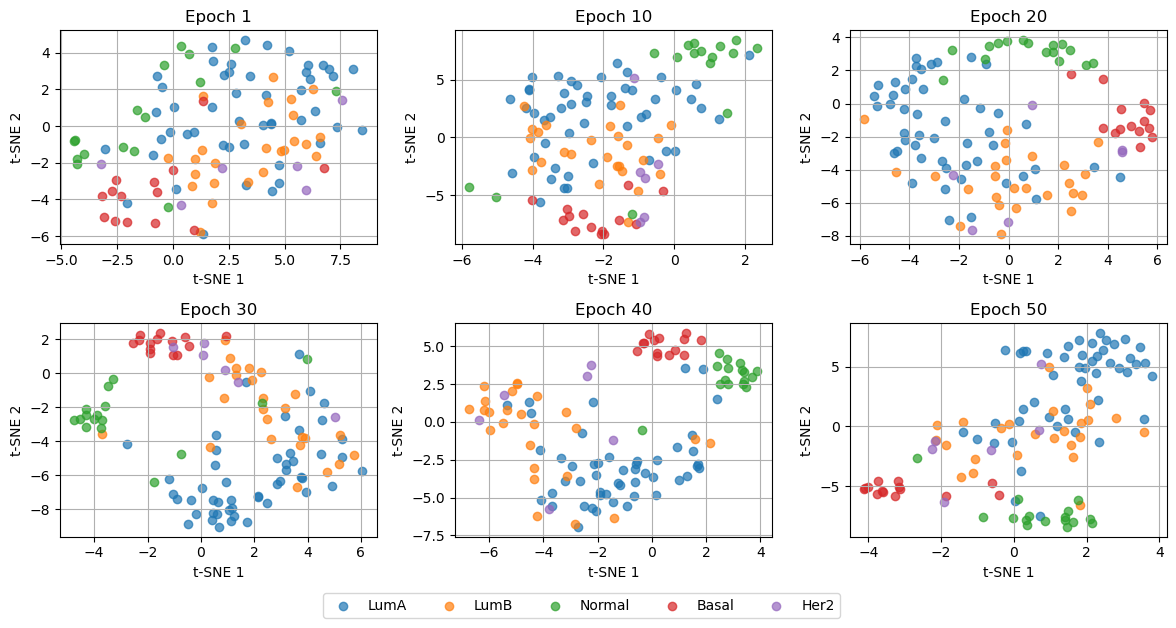

In [53]:

from utils import plot_tsne, plot_loss

plot_tsne(epochs=[1, 10, 20, 30, 40, 50], figsize=(4,3)) 


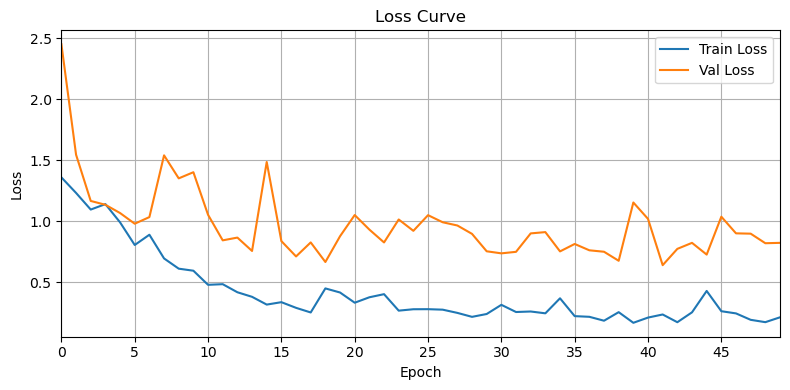

In [54]:
plot_loss(loss_path="logs/loss_history.json", figsize=(8, 4))

In [153]:
for name, param in multiomics_model.named_parameters():
    print(name, param.grad is not None)

methy_encoder.stem.0.weight True
methy_encoder.stem.0.bias True
methy_encoder.stem.1.norm.weight True
methy_encoder.stem.1.norm.bias True
methy_encoder.blocks.0.dwconv.weight True
methy_encoder.blocks.0.dwconv.bias True
methy_encoder.blocks.0.norm.weight True
methy_encoder.blocks.0.norm.bias True
methy_encoder.blocks.0.pwconv1.weight True
methy_encoder.blocks.0.pwconv1.bias True
methy_encoder.blocks.0.pwconv2.weight True
methy_encoder.blocks.0.pwconv2.bias True
methy_encoder.blocks.1.dwconv.weight True
methy_encoder.blocks.1.dwconv.bias True
methy_encoder.blocks.1.norm.weight True
methy_encoder.blocks.1.norm.bias True
methy_encoder.blocks.1.pwconv1.weight True
methy_encoder.blocks.1.pwconv1.bias True
methy_encoder.blocks.1.pwconv2.weight True
methy_encoder.blocks.1.pwconv2.bias True
methy_encoder.head.2.weight True
methy_encoder.head.2.bias True
methy_encoder.head.3.weight True
methy_encoder.head.3.bias True
mirna_vae.encoder.0.weight True
mirna_vae.encoder.0.bias True
mirna_vae.encode

In [158]:
from callbacks.accuracy_recorder import AccuracyRecorderCallback

In [178]:
loss_fn = MultiOmicsLoss(
    beta=0.25,               # Target KL weight
    # annealing_steps=5000,   # Total steps to anneal over
    use_focal=True,
    focal_gamma=2.5,
    label_smoothing=0,
    class_weights=torch.tensor([1.0, 1.0, 1.0, 1.5, 2.5], device="cuda") # or torch.tensor([...], device="cuda")
)

mirna_dim = 1046
rna_exp_dim = 13054
methy_shape = (50, 100)  # e.g., (50, 100)
latent_dim = 32
num_classes = 5

# Instantiate model
multiomics_model = MultiOmicsClassifier(
    mirna_dim=mirna_dim,
    rna_exp_dim=rna_exp_dim,
    methy_shape=methy_shape,
    latent_dim=latent_dim,
    num_classes=num_classes
)




loss_callback = LossRecorderCallback(save_path="logs/loss_history.json")
acc_callback = AccuracyRecorderCallback(save_path=Path("logs/accuracy_history.json"))

tsne_callback = TSNERecorderCallback(
    val_loader=dataloaders['val'],  # Your validation DataLoader
    device='cuda',
    save_path="tsne_results.pkl"  # Matches your plot_tsne() default
)

trainer_cb = CallbackTrainer(
    model=multiomics_model,
    optimizer=torch.optim.AdamW(multiomics_model.parameters(), lr=2e-4, weight_decay=0.0001),
    loss_fn=loss_fn,
    device='cuda', 
    callbacks=[loss_callback, tsne_callback, acc_callback],
    seed=42
)

trainer_cb.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)

/home/CBBI/wangh5/_PyCharm/proj_dl/losses/focal.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('weight', torch.tensor(weight) if weight is not None else None)



Epoch 1/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s, loss=1.38]


Train Loss: 1.4814


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.89it/s]

Val Loss:   3.8506


✅ Val Accuracy: 0.4455

Epoch 2/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.41it/s, loss=0.917]


step    10 | loss: 1.2965 | ce: 1.0445 | kl: 13.2335 | beta: 0.0190
Train Loss: 1.1918


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.11it/s]

Val Loss:   1.6115


✅ Val Accuracy: 0.4818

Epoch 3/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s, loss=1.15]


Train Loss: 1.1250


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.89it/s]

Val Loss:   1.1743


✅ Val Accuracy: 0.5727

Epoch 4/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s, loss=1.67]


Train Loss: 1.1384


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.91it/s]

Val Loss:   1.0338


✅ Val Accuracy: 0.6182

Epoch 5/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.08it/s, loss=0.861]


step    30 | loss: 0.9272 | ce: 0.7048 | kl: 11.5702 | beta: 0.0192
Train Loss: 0.9364


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.27it/s]

Val Loss:   0.9339


✅ Val Accuracy: 0.6273

Epoch 6/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s, loss=0.746]


step    40 | loss: 0.7456 | ce: 0.5722 | kl: 8.9827 | beta: 0.0193
Train Loss: 0.8362


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.12it/s]

Val Loss:   0.9090


✅ Val Accuracy: 0.6545

Epoch 7/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s, loss=0.765]


Train Loss: 0.7835


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.87it/s]

Val Loss:   0.8817


✅ Val Accuracy: 0.5818

Epoch 8/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s, loss=0.934]


step    50 | loss: 0.6979 | ce: 0.4935 | kl: 10.5393 | beta: 0.0194
Train Loss: 0.7465


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.91it/s]

Val Loss:   0.8497


✅ Val Accuracy: 0.6000

Epoch 9/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.56it/s, loss=0.942]


step    60 | loss: 0.6087 | ce: 0.4015 | kl: 10.6294 | beta: 0.0195
Train Loss: 0.7150


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.05it/s]

Val Loss:   0.8403


✅ Val Accuracy: 0.6273

Epoch 10/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s, loss=0.497]


Train Loss: 0.5761


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.28it/s]

Val Loss:   1.0567


✅ Val Accuracy: 0.5909

Epoch 11/50


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.55it/s, loss=0.5]


Train Loss: 0.5390


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.36it/s]

Val Loss:   0.7519


✅ Val Accuracy: 0.6818

Epoch 12/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s, loss=0.542]


step    80 | loss: 0.5084 | ce: 0.3051 | kl: 10.3385 | beta: 0.0197
Train Loss: 0.5294


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.00it/s]

Val Loss:   0.9394


✅ Val Accuracy: 0.3909

Epoch 13/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s, loss=0.684]


Train Loss: 0.5387


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.07it/s]

Val Loss:   0.8522


✅ Val Accuracy: 0.6273

Epoch 14/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s, loss=0.824]


Train Loss: 0.5655


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.36it/s]

Val Loss:   0.9540


✅ Val Accuracy: 0.6364

Epoch 15/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.45it/s, loss=0.42]


step   100 | loss: 0.5035 | ce: 0.2905 | kl: 10.7288 | beta: 0.0199
Train Loss: 0.4420


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.35it/s]

Val Loss:   0.8361


✅ Val Accuracy: 0.6000

Epoch 16/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.00it/s, loss=0.32]


step   110 | loss: 0.3204 | ce: 0.1048 | kl: 10.8136 | beta: 0.0199
Train Loss: 0.4128


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.24it/s]

Val Loss:   0.8343


✅ Val Accuracy: 0.6273

Epoch 17/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.77it/s, loss=0.43]


Train Loss: 0.4064


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.41it/s]

Val Loss:   0.7303


✅ Val Accuracy: 0.6364

Epoch 18/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s, loss=0.669]


step   120 | loss: 0.3930 | ce: 0.1743 | kl: 10.9152 | beta: 0.0200
Train Loss: 0.4275


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.23it/s]

Val Loss:   0.6600


✅ Val Accuracy: 0.7273

Epoch 19/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.03it/s, loss=0.514]


step   130 | loss: 0.3532 | ce: 0.1298 | kl: 11.0997 | beta: 0.0201
Train Loss: 0.4096


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.71it/s]

Val Loss:   0.6787


✅ Val Accuracy: 0.6545

Epoch 20/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s, loss=0.541]


Train Loss: 0.4218


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.93it/s]

Val Loss:   0.7211


✅ Val Accuracy: 0.6000

Epoch 21/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.20it/s, loss=0.322]


Train Loss: 0.3439


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.05it/s]

Val Loss:   0.6489


✅ Val Accuracy: 0.6727

Epoch 22/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s, loss=0.361]


step   150 | loss: 0.4197 | ce: 0.2313 | kl: 9.2747 | beta: 0.0203
Train Loss: 0.3769


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.17it/s]

Val Loss:   0.6334


✅ Val Accuracy: 0.6818

Epoch 23/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s, loss=0.303]


Train Loss: 0.3104


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.15it/s]

Val Loss:   0.9249


✅ Val Accuracy: 0.6182

Epoch 24/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s, loss=0.397]


Train Loss: 0.3270


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.05it/s]

Val Loss:   0.8258


✅ Val Accuracy: 0.7455

Epoch 25/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.11it/s, loss=0.56]


step   170 | loss: 0.3258 | ce: 0.1506 | kl: 8.5470 | beta: 0.0205
Train Loss: 0.3730


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.80it/s]

Val Loss:   0.7356


✅ Val Accuracy: 0.7273

Epoch 26/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s, loss=0.313]


step   180 | loss: 0.3127 | ce: 0.1709 | kl: 6.8873 | beta: 0.0206
Train Loss: 0.3101


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.02it/s]

Val Loss:   0.9685


✅ Val Accuracy: 0.6273

Epoch 27/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s, loss=0.247]


Train Loss: 0.3238


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.34it/s]

Val Loss:   0.8993


✅ Val Accuracy: 0.7364

Epoch 28/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.31it/s, loss=0.401]


step   190 | loss: 0.3401 | ce: 0.1117 | kl: 11.0377 | beta: 0.0207
Train Loss: 0.3383


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.86it/s]

Val Loss:   0.7083


✅ Val Accuracy: 0.7909

Epoch 29/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.32it/s, loss=0.97]


step   200 | loss: 0.3398 | ce: 0.1449 | kl: 9.3754 | beta: 0.0208
Train Loss: 0.4438


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s]

Val Loss:   0.7014


✅ Val Accuracy: 0.7273

Epoch 30/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s, loss=1.49]


Train Loss: 0.5831


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.01it/s]

Val Loss:   0.6276


✅ Val Accuracy: 0.6636

Epoch 31/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s, loss=0.313]


Train Loss: 0.3449


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.90it/s]

Val Loss:   0.6646


✅ Val Accuracy: 0.6091

Epoch 32/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s, loss=0.467]


step   220 | loss: 0.4614 | ce: 0.2238 | kl: 11.3276 | beta: 0.0210
Train Loss: 0.3772


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.97it/s]

Val Loss:   0.7039


✅ Val Accuracy: 0.6636

Epoch 33/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.73it/s, loss=0.376]


Train Loss: 0.2916


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.15it/s]

Val Loss:   0.7816


✅ Val Accuracy: 0.6000

Epoch 34/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s, loss=0.176]


Train Loss: 0.2605


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.61it/s]

Val Loss:   0.7376


✅ Val Accuracy: 0.6636

Epoch 35/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.31it/s, loss=0.463]


step   240 | loss: 0.2448 | ce: 0.0765 | kl: 7.9533 | beta: 0.0212
Train Loss: 0.3136


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.05it/s]

Val Loss:   0.9877


✅ Val Accuracy: 0.6455

Epoch 36/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s, loss=0.192]


step   250 | loss: 0.1916 | ce: 0.0275 | kl: 7.7174 | beta: 0.0213
Train Loss: 0.2893


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.17it/s]

Val Loss:   0.8075


✅ Val Accuracy: 0.7455

Epoch 37/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s, loss=0.24]


Train Loss: 0.2735


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.92it/s]

Val Loss:   0.5716


✅ Val Accuracy: 0.7273

Epoch 38/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.57it/s, loss=0.21]


step   260 | loss: 0.2608 | ce: 0.0743 | kl: 8.7328 | beta: 0.0214
Train Loss: 0.2498


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.16it/s]

Val Loss:   0.6205


✅ Val Accuracy: 0.6909

Epoch 39/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s, loss=0.309]


step   270 | loss: 0.2752 | ce: 0.1248 | kl: 7.0083 | beta: 0.0215
Train Loss: 0.2647


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.83it/s]

Val Loss:   0.7090


✅ Val Accuracy: 0.7091

Epoch 40/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.05it/s, loss=0.162]


Train Loss: 0.2296


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.85it/s]

Val Loss:   0.7421


✅ Val Accuracy: 0.7273

Epoch 41/50


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.49it/s, loss=0.69]


Train Loss: 0.3469


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.09it/s]

Val Loss:   0.7709


✅ Val Accuracy: 0.7364

Epoch 42/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.93it/s, loss=0.521]


step   290 | loss: 0.2810 | ce: 0.1364 | kl: 6.6762 | beta: 0.0217
Train Loss: 0.3217


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.16it/s]

Val Loss:   0.7529


✅ Val Accuracy: 0.6455

Epoch 43/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.50it/s, loss=0.285]


Train Loss: 0.2794


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.52it/s]

Val Loss:   0.7464


✅ Val Accuracy: 0.6273

Epoch 44/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s, loss=0.238]


Train Loss: 0.2759


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.21it/s]

Val Loss:   0.9171


✅ Val Accuracy: 0.6273

Epoch 45/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.39it/s, loss=0.218]


step   310 | loss: 0.2396 | ce: 0.0448 | kl: 8.9149 | beta: 0.0219
Train Loss: 0.2495


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.01it/s]

Val Loss:   0.8843


✅ Val Accuracy: 0.6273

Epoch 46/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.15it/s, loss=0.246]


step   320 | loss: 0.2457 | ce: 0.0812 | kl: 7.4943 | beta: 0.0220
Train Loss: 0.2369


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.22it/s]

Val Loss:   0.7561


✅ Val Accuracy: 0.6909

Epoch 47/50


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.69it/s, loss=0.3]


Train Loss: 0.2812


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.30it/s]

Val Loss:   0.5316


✅ Val Accuracy: 0.6545

Epoch 48/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.16it/s, loss=0.766]


step   330 | loss: 0.2363 | ce: 0.0783 | kl: 7.1645 | beta: 0.0221
Train Loss: 0.3778


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.19it/s]

Val Loss:   0.7736


✅ Val Accuracy: 0.6636

Epoch 49/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.92it/s, loss=0.372]


step   340 | loss: 0.3807 | ce: 0.1173 | kl: 11.8902 | beta: 0.0222
Train Loss: 0.3598


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.58it/s]

Val Loss:   0.7380


✅ Val Accuracy: 0.6091

Epoch 50/50


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.23it/s, loss=0.502]


Train Loss: 0.3695


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.33it/s]

Val Loss:   0.7451


✅ Val Accuracy: 0.7091


In [190]:
from utils import set_seed
set_seed(1111)
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

✅ Test Accuracy: 0.5758
              precision    recall  f1-score   support

           0       0.64      0.55      0.59        29
           1       0.38      0.40      0.39        15
           2       0.67      0.89      0.76         9
           3       0.70      0.78      0.74         9
           4       0.33      0.25      0.29         4

    accuracy                           0.58        66
   macro avg       0.54      0.57      0.55        66
weighted avg       0.57      0.58      0.57        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 0.25,
        "use_focal": true,
        "focal_gamma": 2.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "AdamW",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0.0001
    }
}


In [193]:
import numpy as np
from sklearn.metrics import accuracy_score
from utils import set_seed
import torch

def evaluate_multiple_seeds(trainer, test_loader, seeds=100):
    accs = []

    for seed in np.random.randint(0, 10_000, size=seeds):
        set_seed(int(seed))  # Reset seed
        preds, targets = trainer.predict(test_loader)
        acc = accuracy_score(targets.numpy(), preds.numpy())
        accs.append(acc)

    accs = np.array(accs)
    print(f"\n✅ Avg Accuracy over {seeds} seeds: {accs.mean():.4f} ± {accs.std():.4f}")
    return accs
accs = evaluate_multiple_seeds(trainer_cb, dataloaders["test"], seeds=100)



✅ Avg Accuracy over 100 seeds: 0.6523 ± 0.0468


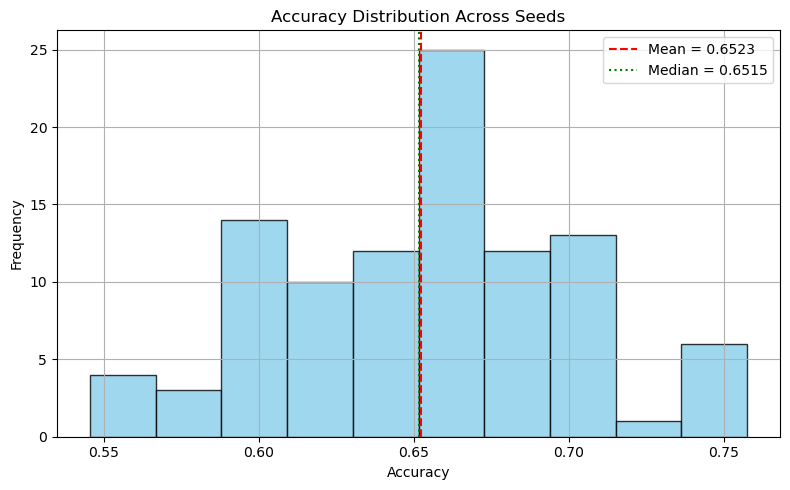

In [195]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_distribution(accs, bins=10, title="Accuracy Distribution Across Seeds"):
    plt.figure(figsize=(8, 5))
    plt.hist(accs, bins=bins, color="skyblue", edgecolor="black", alpha=0.8)
    plt.axvline(np.mean(accs), color='red', linestyle='--', label=f"Mean = {np.mean(accs):.4f}")
    plt.axvline(np.median(accs), color='green', linestyle=':', label=f"Median = {np.median(accs):.4f}")
    
    plt.title(title)
    plt.xlabel("Accuracy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_accuracy_distribution(accs)

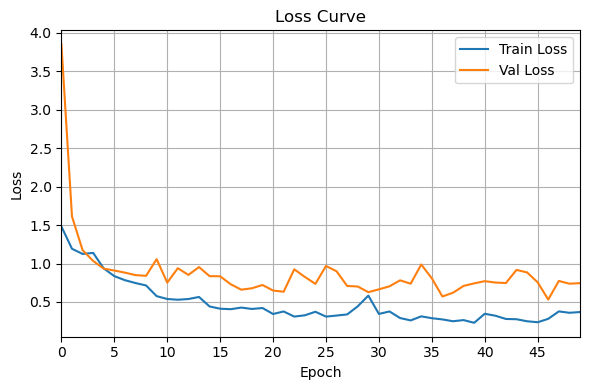

In [198]:
plot_loss(loss_path="logs/loss_history.json", figsize=(6, 4))

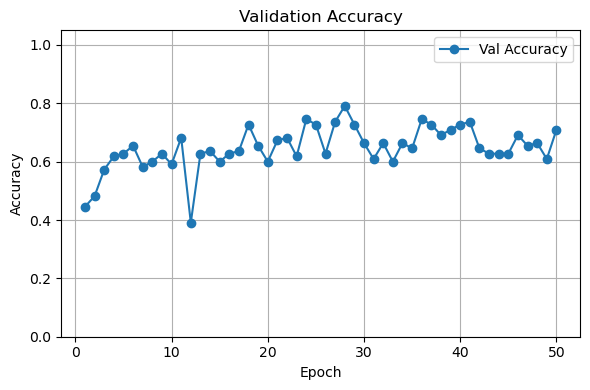

In [199]:
from utils import plot_accuracy
plot_accuracy("logs/accuracy_history.json", figsize=(6, 4))

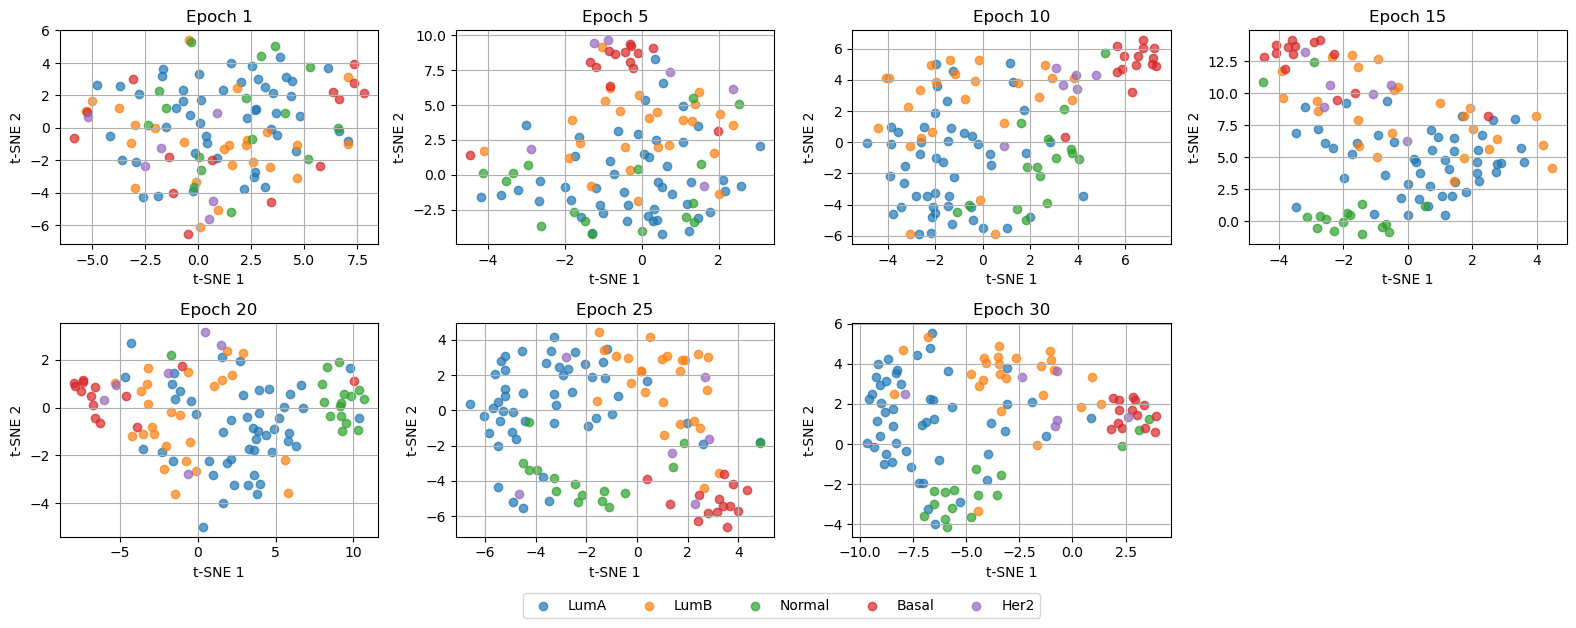

In [200]:
plot_tsne(epochs=[1, 5, 10, 15, 20, 25, 30], cols=4, figsize=(4, 3))

In [100]:
preds, targets = trainer_cb.predict(dataloaders["test"])
acc = accuracy_score(targets.numpy(), preds.numpy())
print(f"✅ Test Accuracy: {acc:.4f}")

print(classification_report(targets.numpy(), preds.numpy()))
params = get_training_parameters(trainer_cb)

print(json.dumps(params, indent=4))

✅ Test Accuracy: 0.6970
              precision    recall  f1-score   support

           0       0.74      0.69      0.71        29
           1       0.53      0.60      0.56        15
           2       0.78      0.78      0.78         9
           3       0.80      0.89      0.84         9
           4       0.67      0.50      0.57         4

    accuracy                           0.70        66
   macro avg       0.70      0.69      0.69        66
weighted avg       0.70      0.70      0.70        66

{
    "training": {
        "device": "cuda"
    },
    "loss": {
        "type": "MultiOmicsLoss",
        "beta": 0.25,
        "use_focal": true,
        "focal_gamma": 2.5,
        "label_smoothing": 0,
        "kl_epsilon": 1e-08
    },
    "optimizer": {
        "type": "Adam",
        "lr": 0.0002,
        "betas": [
            0.9,
            0.999
        ],
        "eps": 1e-08,
        "weight_decay": 0
    }
}


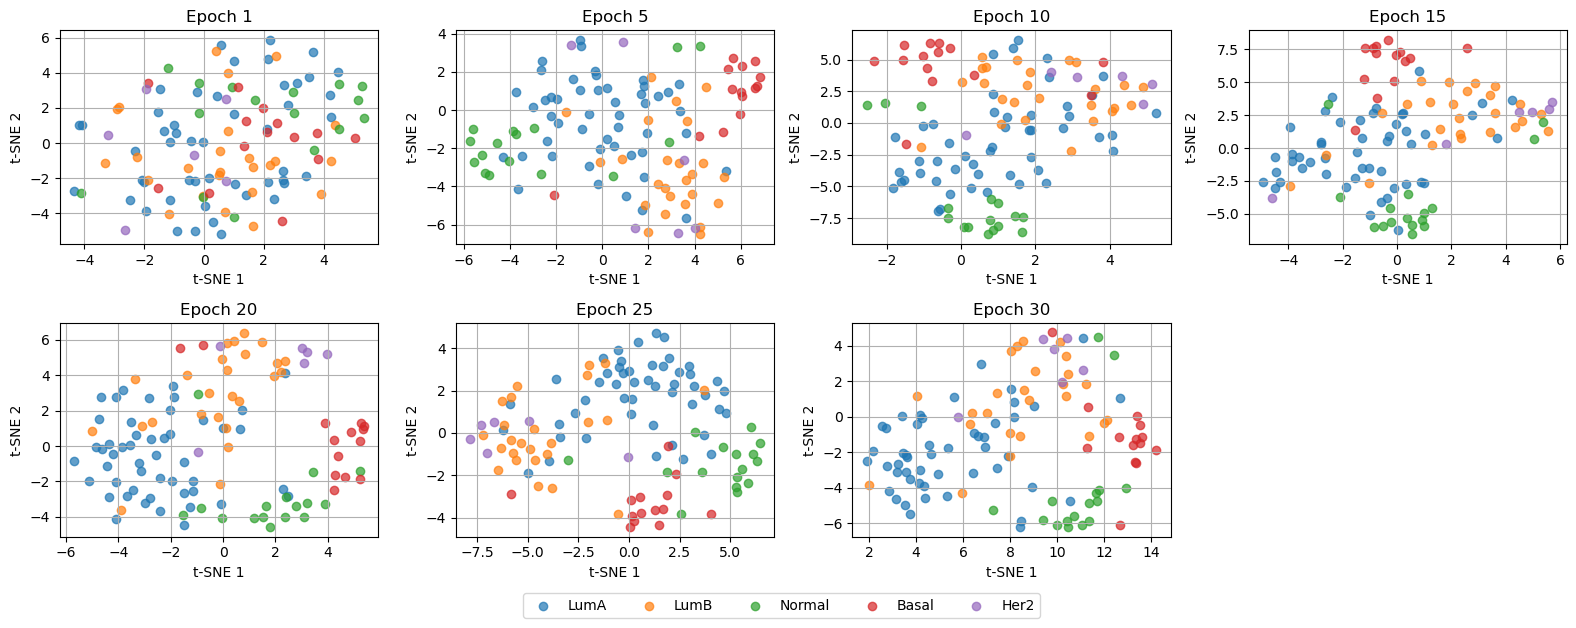

In [103]:
from utils import plot_tsne, plot_loss

plot_tsne(epochs=[1, 5, 10, 15, 20, 25, 30], cols=4, figsize=(4, 3))

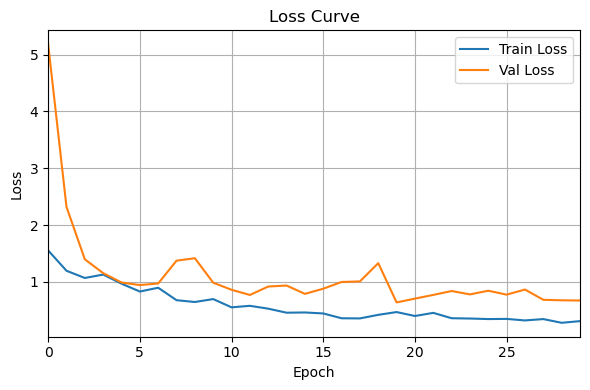

In [104]:
plot_loss(loss_path="logs/loss_history.json", figsize=(6, 4))

In [105]:
preds, targets, logits = trainer_cb.predict(dataloaders["test"], return_logits=True)

In [50]:
import torch.nn.functional as F
probs = F.softmax(logits, dim=1)
predictions = torch.argmax(probs, dim=1)

predictions 

tensor([1, 1, 1, 1, 0, 0, 3, 4, 0, 1, 3, 3, 0, 1, 0, 2, 0, 0, 3, 2, 0, 1, 4, 3,
        0, 0, 0, 1, 1, 3, 1, 2, 3, 1, 1, 0, 3, 0, 1, 0, 1, 3, 2, 1, 0, 0, 2, 0,
        0, 4, 2, 0, 1, 3, 3, 1, 0, 4, 0, 1, 3, 0, 0, 0, 0, 2])